In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dgp_palette = sns.color_palette("pastel", 6)
color_map_dgps = {f'dgp{i+1}': dgp_palette[i] for i in range(6)}
tab10 = plt.get_cmap("tab10").colors

color_map_models = {
    'lasso': tab10[0],     
    'rf': tab10[1],        
    'xgb': tab10[2],       
    'stacking': tab10[3],  
    'oracle': tab10[4],     
    'combined_loss': tab10[5], 
    'y_error': tab10[6]  
}

hatch_map_models = {
    'lasso': '//',
    'rf': '\\\\',
    'xgb': 'xx',
    'stacking': '..',
    'oracle': '**'
}

linestyle_map_models = {
    'lasso': 'solid',
    'rf': 'dashed',
    'xgb': 'dotted',
    'stacking': 'dashdot',
    'oracle': (0, (3, 1, 1, 1))
}

marker_map_models = {
    'lasso': 'o',
    'rf': 's',
    'xgb': '^',
    'stacking': 'D',
    'oracle': 'P'
}

In [3]:
dfs_of = defaultdict(dict)
dfs_fs = defaultdict(dict)

dgps = ['dgp1', 'dgp2', 'dgp3', 'dgp4', 'dgp5', 'dgp6']
models = ['lasso', 'rf', 'xgb', 'stacking', 'oracle']
models_without_oracle = ['lasso', 'rf', 'xgb', 'stacking']

# ON FOLDS
for dgp in dgps:
    dfs_of[dgp] = pd.read_csv(f'results_of/results_MNAR_{dgp}_on_folds.csv')
    
# FULL SAMPLE
for dgp in dgps:
    dfs_fs[dgp] = pd.read_csv(f'results_fs/results_MNAR_{dgp}_full_sample.csv')

# rRMSE Bias

In [4]:
# ON-FOLDS
relative_rmses_of = {}
relative_se_of = {}

for dgp in dgps:
    oracle_bias = dfs_of[dgp][dfs_of[dgp]['model']=='oracle']['bias']
    rmse_oracle = np.sqrt(np.mean(oracle_bias**2))
    
    for model_type in models_without_oracle:
        df_temp = dfs_of[dgp][dfs_of[dgp]['model'] == model_type]
        bias = df_temp['bias']
        rmse_current = np.sqrt(np.mean(bias**2))
        
        # rRMSE
        rel_rmse = rmse_current / rmse_oracle
        relative_rmses_of[(dgp, model_type)] = rel_rmse
        
        # Delta method approximation for SE:
        # Var(X/Y) ≈ (1/Y²) * Var(X)   (assuming Y is constant here, since oracle is fixed)
        n = len(bias)
        var_rmse_current = np.var(bias**2) / (4 * n * rmse_current**2)  # delta method
        se_rel_rmse = np.sqrt(var_rmse_current) / rmse_oracle
        relative_se_of[(dgp, model_type)] = se_rel_rmse

relative_rmses_fs = {}
relative_se_fs = {}

# FULL SAMPLE
for dgp in dgps:
    oracle_bias = dfs_fs[dgp][dfs_fs[dgp]['model']=='oracle']['bias']
    rmse_oracle = np.sqrt(np.mean(oracle_bias**2))
    
    for model_type in models_without_oracle:
        df_temp = dfs_fs[dgp][dfs_fs[dgp]['model'] == model_type]
        bias = df_temp['bias']
        rmse_current = np.sqrt(np.mean(bias**2))
        
        # rRMSE
        rel_rmse = rmse_current / rmse_oracle
        relative_rmses_fs[(dgp, model_type)] = rel_rmse
        
        # Delta method approximation for SE:
        # Var(X/Y) ≈ (1/Y²) * Var(X)   (assuming Y is constant here, since oracle is fixed)
        n = len(bias)
        var_rmse_current = np.var(bias**2) / (4 * n * rmse_current**2)  # delta method
        se_rel_rmse = np.sqrt(var_rmse_current) / rmse_oracle
        relative_se_fs[(dgp, model_type)] = se_rel_rmse

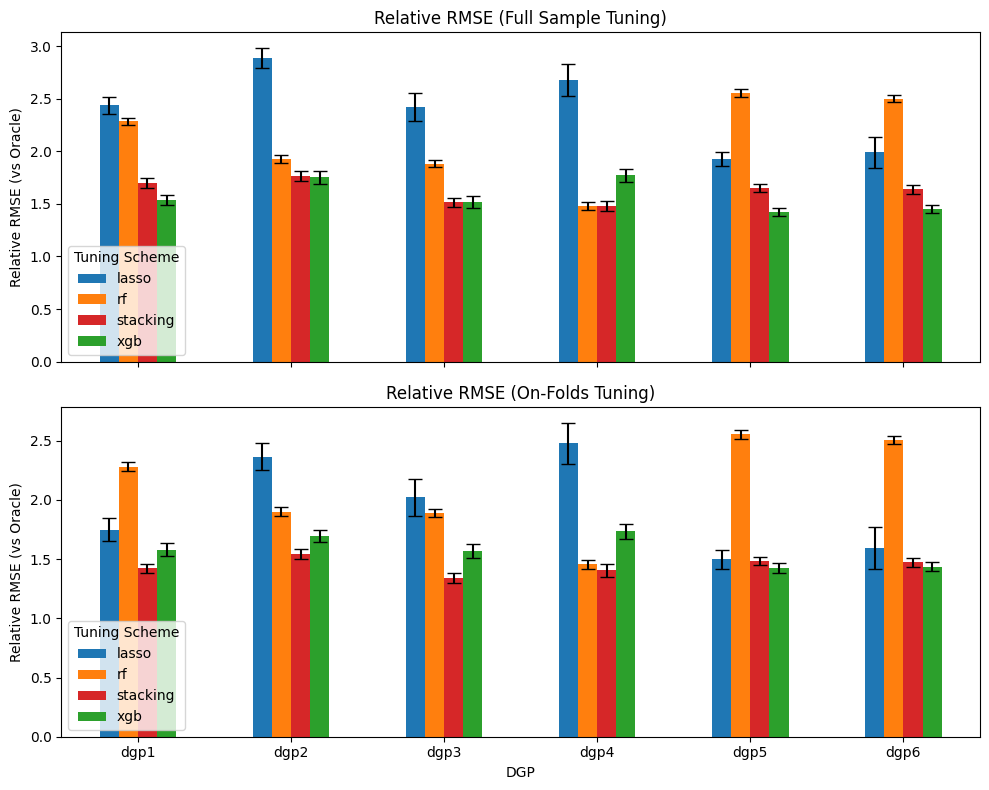

In [5]:
# Prepare data for plotting
df_plot_fs = pd.Series(relative_rmses_fs).unstack()
df_se_fs = pd.Series(relative_se_fs).unstack()

df_plot_of = pd.Series(relative_rmses_of).unstack()
df_se_of = pd.Series(relative_se_of).unstack()

# Set the index to DGPs
colors_fs = [color_map_models.get(col, "gray") for col in df_plot_fs.columns]
colors_of = [color_map_models.get(col, "gray") for col in df_plot_of.columns]
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

# Full Sample plot
df_plot_fs.plot(kind='bar', yerr=df_se_fs, capsize=5, ax=axes[0], color=colors_fs)
axes[0].set_ylabel("Relative RMSE (vs Oracle)")
axes[0].set_title("Relative RMSE (Full Sample Tuning)")
axes[0].legend(title="Tuning Scheme")
axes[0].tick_params(axis='x', rotation=0)

# On-Folds plot
df_plot_of.plot(kind='bar', yerr=df_se_of, capsize=5, ax=axes[1], color=colors_of)
axes[1].set_ylabel("Relative RMSE (vs Oracle)")
axes[1].set_title("Relative RMSE (On-Folds Tuning)")
axes[1].set_xlabel("DGP")
axes[1].legend(title="Tuning Scheme")
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# relative RMSE gathered

In [7]:
# ON FOLDS
df_rmses_of = pd.DataFrame([
    {"DGP": dgp, "Model": model, "Relative RMSE": relative_rmses_of[(dgp, model)]}
    for (dgp, model) in relative_rmses_of
])

# FULL SAMPLE
df_rmses_fs = pd.DataFrame([
    {"DGP": dgp, "Model": model, "Relative RMSE": relative_rmses_fs[(dgp, model)]}
    for (dgp, model) in relative_rmses_fs
])


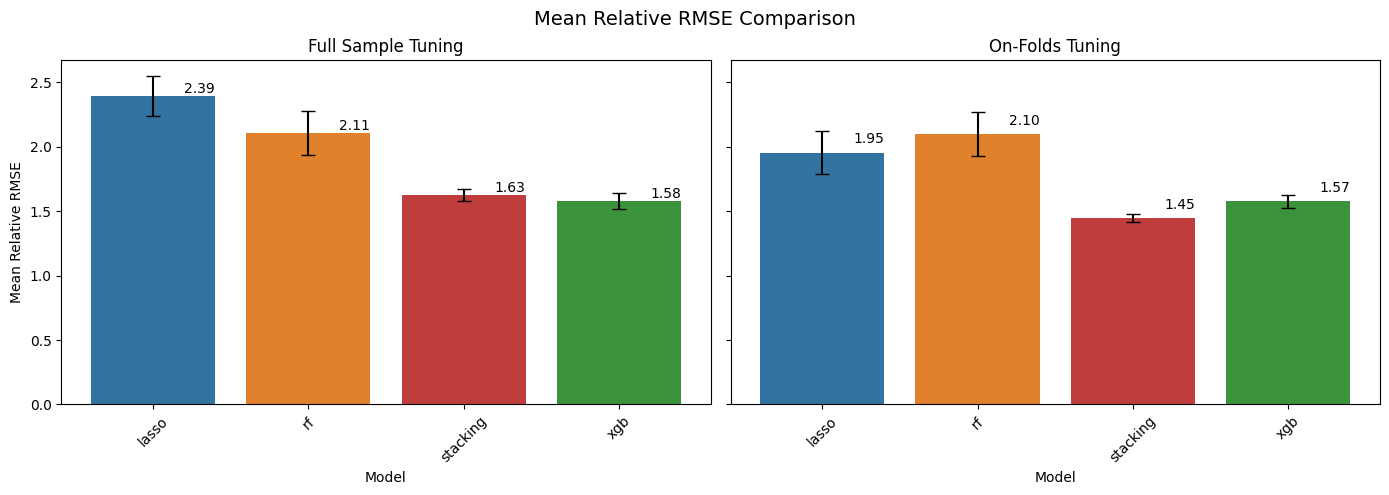

In [ ]:
def make_bar_df(relative_rmses):
    df = pd.Series(relative_rmses).reset_index()
    df.columns = ["Simulation", "Model", "Relative RMSE"]
    df_bar = (
        df.groupby("Model")["Relative RMSE"]
        .agg(["mean", "sem"])
        .reset_index()
        .rename(columns={"mean": "Mean Relative RMSE", "sem": "SE"})
    )
    return df_bar

df_bar_fs = make_bar_df(relative_rmses_fs)
df_bar_of = make_bar_df(relative_rmses_of)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# FS Plot
sns.barplot(
    data=df_bar_fs,
    x="Model",
    y="Mean Relative RMSE",
    hue="Model",
    palette=[color_map_models.get(model, '#333333') for model in df_bar_fs['Model']],
    ax=axes[0],
    dodge=False,
    capsize=0.1
)
for i, row in df_bar_fs.iterrows():
    axes[0].errorbar(x=i, y=row["Mean Relative RMSE"], yerr=row["SE"], fmt='none', c='black', capsize=5, linewidth=1.5)
    axes[0].text(i + 0.3, row["Mean Relative RMSE"], 
                 f'{row["Mean Relative RMSE"]:.2f}', 
                 ha='center', va='bottom', fontsize=10)
    

axes[0].set_title("Full Sample Tuning")
axes[0].set_ylabel("Mean Relative RMSE")
axes[0].set_xlabel("Model")
axes[0].tick_params(axis='x', rotation=45)

# OF Plot
sns.barplot(
    data=df_bar_of,
    x="Model",
    y="Mean Relative RMSE",
    hue="Model",
    palette=[color_map_models.get(model, '#333333') for model in df_bar_of['Model']],
    ax=axes[1],
    dodge=False,
    capsize=0.1
)
for i, row in df_bar_of.iterrows():
    axes[1].errorbar(x=i, y=row["Mean Relative RMSE"], yerr=row["SE"], fmt='none', c='black', capsize=5, linewidth=1.5)
    axes[1].text(i + 0.3, row["Mean Relative RMSE"] + 0.05, f'{row["Mean Relative RMSE"]:.2f}', 
                 ha='center', va='bottom', fontsize=10)
    
axes[1].set_title("On-Folds Tuning")
axes[1].set_ylabel("")
axes[1].set_xlabel("Model")
axes[1].tick_params(axis='x', rotation=45)

plt.suptitle("Mean Relative RMSE Comparison", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.88) 
plt.show()


# Nuisance Errors

In [ ]:
def compute_summary(dfs):
    summary = []

    for dgp in dgps:
        for model in models:
            subset = dfs[dgp][dfs[dgp]['model'] == model]

            pi_loss = subset['ml_pi_log_loss']
            m_loss = subset['ml_m_log_loss']
            g_rmse   = subset['ml_g_rmse']

            # Combined loss
            combined_loss = g_rmse * (pi_loss + m_loss)

            summary.append({
                'DGP': dgp,
                'Model': model,
                'Mean logloss(π)': pi_loss.mean(),
                'SE logloss(π)': pi_loss.std(ddof=1) / np.sqrt(len(pi_loss)),
                'Mean logloss(m)': m_loss.mean(),
                'SE logloss(m)': m_loss.std(ddof=1) / np.sqrt(len(m_loss)),
                'Mean RMSE(g)': g_rmse.mean(),
                'SE RMSE(g)': g_rmse.std(ddof=1) / np.sqrt(len(g_rmse)),
                'Mean Combined Loss': combined_loss.mean(),
                'SE Combined Loss': combined_loss.std(ddof=1) / np.sqrt(len(combined_loss))
            })

    return pd.DataFrame(summary)

df_summary_of = compute_summary(dfs_of)
df_summary_fs = compute_summary(dfs_fs)


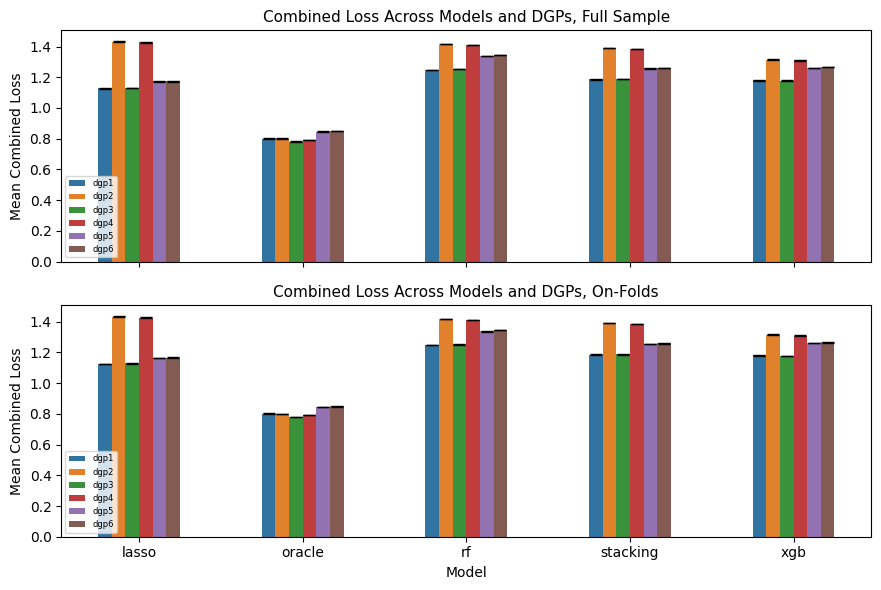

In [ ]:
def plot_metric_bar_dual(df_summary_fs, df_summary_of, metric_col, se_col, title_fs, title_of):
    import matplotlib.pyplot as plt
    import seaborn as sns

    df_summary_fs_sorted = df_summary_fs.sort_values(by=['Model', 'DGP']).reset_index(drop=True)
    df_summary_of_sorted = df_summary_of.sort_values(by=['Model', 'DGP']).reset_index(drop=True)

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 6), sharex=True)

    for ax, df_summary_sorted, title in zip(axes, [df_summary_fs_sorted, df_summary_of_sorted], [title_fs, title_of]):
        sns.barplot(
            data=df_summary_sorted,
            x='Model',
            y=metric_col,
            hue='DGP',
            errorbar=None,
            dodge=True,
            ax=ax,
            width=0.5
        )

        for idx, patch in enumerate(ax.patches[:len(df_summary_sorted)]):
            row = df_summary_sorted.iloc[idx]
            x = patch.get_x() + patch.get_width() / 2
            y = patch.get_height()
            se = row[se_col]
            ax.errorbar(x=x, y=y, yerr=se, fmt='none', c='black', capsize=4, linewidth=1.2)

        ax.set_title(title, fontsize=11)
        ax.set_ylabel(metric_col)
        ax.tick_params(axis='x', rotation=0)
        ax.legend(fontsize=6)

    plt.xlabel("Model")
    plt.tight_layout()
    plt.show()

# for combined loss
plot_metric_bar_dual(df_summary_fs, df_summary_of, 'Mean Combined Loss', 'SE Combined Loss', 'Combined Loss Across Models and DGPs, Full Sample', 'Combined Loss Across Models and DGPs, On-Folds')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.gridspec import GridSpec

def plot_all_metrics_vertically(df_summary, title):
    metrics = [
        ('Mean logloss(π)', 'SE logloss(π)', 'Log Loss (π)'),
        ('Mean logloss(m)', 'SE logloss(m)', 'Log Loss (m)'),
        ('Mean RMSE(g)', 'SE RMSE(g)', 'RMSE (g)')
    ]

    df_summary_sorted = df_summary.sort_values(by=['Model', 'DGP']).reset_index(drop=True)

    fig = plt.figure(figsize=(8, 9))
    gs = GridSpec(3, 1, hspace=0.5)

    axes = [fig.add_subplot(gs[i, 0]) for i in range(3)]

    for i, (metric_col, se_col, subtitle) in enumerate(metrics):
        ax = axes[i]

        sns.barplot(
            data=df_summary_sorted,
            x='Model',
            y=metric_col,
            hue='DGP',
            errorbar=None,
            dodge=True,
            width=0.5,
            ax=ax
        )

        for idx, patch in enumerate(ax.patches[:len(df_summary_sorted)]):
            row = df_summary_sorted.iloc[idx]
            x = patch.get_x() + patch.get_width() / 2
            y = patch.get_height()
            se = row[se_col]
            ax.errorbar(x=x, y=y, yerr=se, fmt='none', c='black', capsize=4, linewidth=1.2)

        ax.set_title(subtitle, fontsize=12)
        ax.set_xlabel('')
        ax.set_ylabel('Error')
        ax.set_ylim(bottom=0)

        # Legend only for one
        if i < 2:
            ax.get_legend().remove()
        else:
            ax.legend(title='DGP', fontsize=6, title_fontsize=10, loc='upper right')

    fig.suptitle(title, fontsize=16, y=0.98)
    plt.show()

# Nuisance Errors Grouped by DGPs

In [ ]:
# FOR ON FOLDS

losses_of = []

for dgp in df_summary_of['DGP'].unique():
    df_dgp = df_summary_of[df_summary_of['DGP'] == dgp]
    oracle_row = df_dgp[df_dgp['Model'] == 'oracle'].iloc[0]
    
    for _, row in df_dgp.iterrows():
        if row['Model'] == 'oracle':
            continue  # no oracle comparison
        
        losses_of.append({
            'DGP': dgp,
            'Model': row['Model'],
            'Combined Loss': row['Mean Combined Loss'],
            'logloss(π)': row['Mean logloss(π)'],
            'logloss(m)': row['Mean logloss(m)'],
            'RMSE(g)': row['Mean RMSE(g)']
        })

df_mean_summary_of = pd.DataFrame(losses_of)

# FOR FULL SAMPLE
losses_fs = []
for dgp in df_summary_fs['DGP'].unique():
    df_dgp = df_summary_fs[df_summary_fs['DGP'] == dgp]
    oracle_row = df_dgp[df_dgp['Model'] == 'oracle'].iloc[0]
    
    for _, row in df_dgp.iterrows():
        if row['Model'] == 'oracle':
            continue  # no oracle comparison
        
        losses_fs.append({
            'DGP': dgp,
            'Model': row['Model'],
            'Combined Loss': row['Mean Combined Loss'],
            'logloss(π)': row['Mean logloss(π)'],
            'logloss(m)': row['Mean logloss(m)'],
            'RMSE(g)': row['Mean RMSE(g)'],
        })

df_mean_summary_fs = pd.DataFrame(losses_fs)


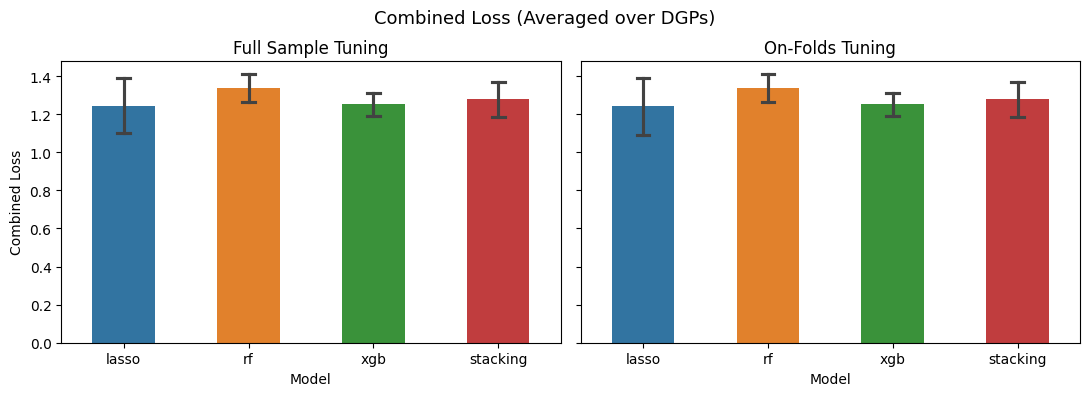

In [13]:
def plot_relative_combined_loss_dual(df_mean_summary_fs, df_mean_summary_of):
    import matplotlib.pyplot as plt
    import seaborn as sns

    fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharey=True)

    # --- FS Plot ---
    sns.barplot(
        data=df_mean_summary_fs,
        x='Model',
        y='Combined Loss',
        estimator='mean',
        errorbar='sd',
        capsize=0.1,
        hue='Model',
        width=0.5,
        ax=axes[0],
        dodge=False
    )
    axes[0].set_title('Full Sample Tuning')
    axes[0].set_ylabel('Combined Loss')
    axes[0].set_xlabel('Model')
    axes[0].tick_params(axis='x', rotation=0)

    means_fs = df_mean_summary_fs.groupby("Model")["Combined Loss"].mean()
    stds_fs = df_mean_summary_fs.groupby("Model")["Combined Loss"].std()

    # --- OF Plot ---
    sns.barplot(
        data=df_mean_summary_of,
        x='Model',
        y='Combined Loss',
        estimator='mean',
        errorbar='sd',
        capsize=0.1,
        hue='Model',
        width=0.5,
        ax=axes[1],
        dodge=False
    )
    axes[1].set_title('On-Folds Tuning')
    axes[1].set_ylabel('')
    axes[1].set_xlabel('Model')
    axes[1].tick_params(axis='x', rotation=0)

    means_of = df_mean_summary_of.groupby("Model")["Combined Loss"].mean()
    stds_of = df_mean_summary_of.groupby("Model")["Combined Loss"].std()


    plt.suptitle("Combined Loss (Averaged over DGPs)", fontsize=13)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

plot_relative_combined_loss_dual(df_mean_summary_fs, df_mean_summary_of)

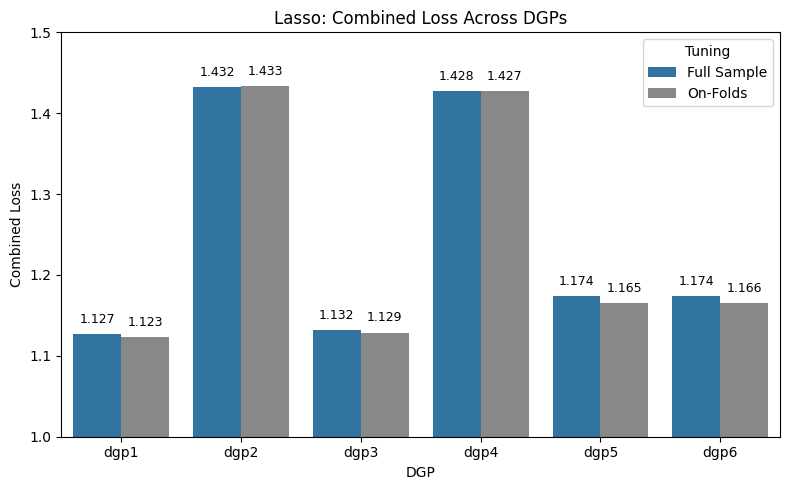

In [ ]:
def plot_lasso_relative_loss_dgp_grouped(df_rel_fs, df_rel_of):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    df_lasso_fs = df_rel_fs[df_rel_fs['Model'] == 'lasso'].copy()
    df_lasso_of = df_rel_of[df_rel_of['Model'] == 'lasso'].copy()

    df_lasso_fs['Tuning'] = 'Full Sample'
    df_lasso_of['Tuning'] = 'On-Folds'

    df_combined = pd.concat([df_lasso_fs, df_lasso_of], ignore_index=True)

    dgp_order = sorted(df_combined['DGP'].unique())
    tuning_order = ['Full Sample', 'On-Folds']

    plt.figure(figsize=(8, 5))
    ax = sns.barplot(
        data=df_combined,
        x='DGP',
        y='Combined Loss',
        hue='Tuning',
        estimator='mean',
        errorbar='sd',
        capsize=0.1,
        order=dgp_order,
        hue_order=tuning_order,
        palette={
            'Full Sample': color_map_models['lasso'],
            'On-Folds': "#888888"  # gri tonlu alternatif renk
        }
    )

    means = df_combined.groupby(['DGP', 'Tuning'])["Combined Loss"].mean().unstack()
    for i, dgp in enumerate(dgp_order):
        for j, tuning in enumerate(tuning_order):
            y = means.loc[dgp, tuning]
            x = i + (-0.2 if tuning == 'Full Sample' else 0.2)
            ax.text(x, y + 0.01, f'{y:.3f}', ha='center', va='bottom', fontsize=9)

    ax.set_title("Lasso: Combined Loss Across DGPs")
    ax.set_ylabel("Combined Loss")
    ax.set_xlabel("DGP")
    ax.tick_params(axis='x', rotation=0)
    ax.legend(title="Tuning")
    plt.tight_layout()
    plt.ylim(1, 1.5)
    plt.show()

plot_lasso_relative_loss_dgp_grouped(df_mean_summary_fs, df_mean_summary_of)

# Coverage

In [18]:
def get_coverage(lower, upper, true_value):
    return np.mean((lower <= true_value) & (true_value <= upper))

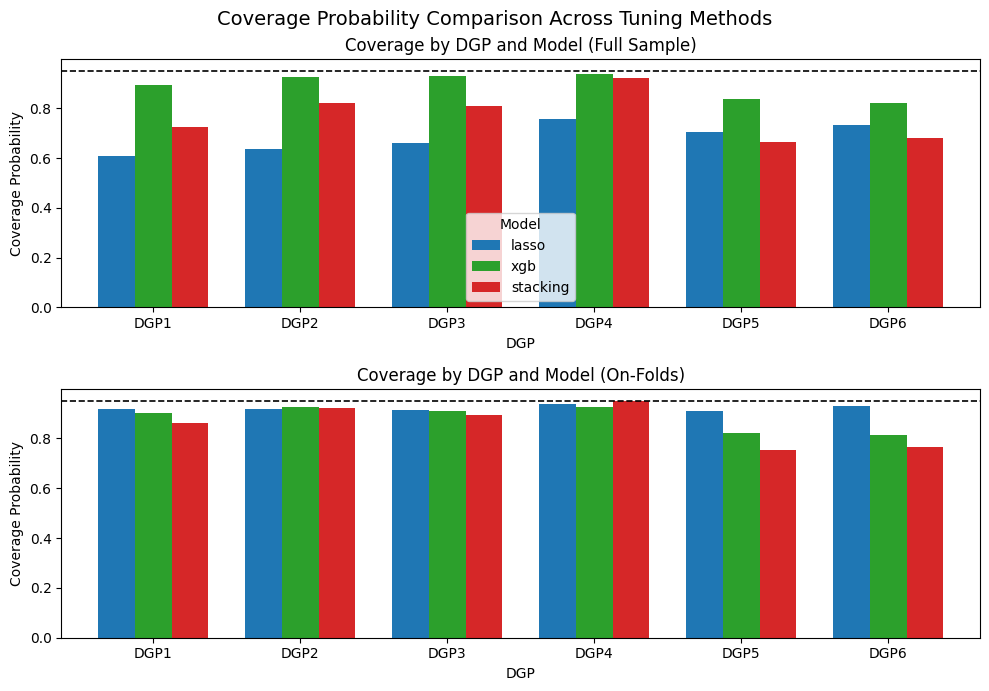

In [19]:
def plot_coverage_dual(dfs_fs, dfs_of, dgps, models_without_oracle):
    import matplotlib.pyplot as plt
    import pandas as pd

    def compute_coverage_df(dfs):
        data = []
        for dgp in dgps:
            for model_type in models_without_oracle:
                df_temp = dfs[dgp][dfs[dgp]['model'] == model_type]
                coverage = get_coverage(df_temp['2.5 %'], df_temp['97.5 %'], 1)
                data.append({
                    'DGP': dgp.upper(),
                    'Model': model_type,
                    'Coverage': coverage
                })
        df_plot = pd.DataFrame(data)
        pivot_df = df_plot.pivot(index='DGP', columns='Model', values='Coverage')
        pivot_df = pivot_df[models_without_oracle]  # Model sırası garanti olsun
        return pivot_df

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 7), sharey=True)

    # --- Full Sample ---
    pivot_fs = compute_coverage_df(dfs_fs)
    pivot_fs.plot(
        kind='bar',
        width=0.75,
        color=[color_map_models[m] for m in pivot_fs.columns],
        ax=axes[0]
    )
    axes[0].axhline(0.95, linestyle='--', color='black', linewidth=1.2)
    axes[0].set_title('Coverage by DGP and Model (Full Sample)')
    axes[0].set_ylabel('Coverage Probability')
    axes[0].tick_params(axis='x', rotation=0)
    axes[0].legend(title='Model')

    # --- On-Folds ---
    pivot_of = compute_coverage_df(dfs_of)
    pivot_of.plot(
        kind='bar',
        width=0.75,
        color=[color_map_models[m] for m in pivot_of.columns],
        ax=axes[1]
    )
    axes[1].axhline(0.95, linestyle='--', color='black', linewidth=1.2)
    axes[1].set_title('Coverage by DGP and Model (On-Folds)')
    axes[1].set_ylabel('Coverage Probability')
    axes[1].set_xlabel('DGP')
    axes[1].tick_params(axis='x', rotation=0)
    axes[1].legend(title='Model').remove()

    plt.suptitle("Coverage Probability Comparison Across Tuning Methods", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.91)
    plt.show()


plot_coverage_dual(dfs_fs, dfs_of, dgps, ['lasso', 'xgb', 'stacking'])

# Bias Distribution

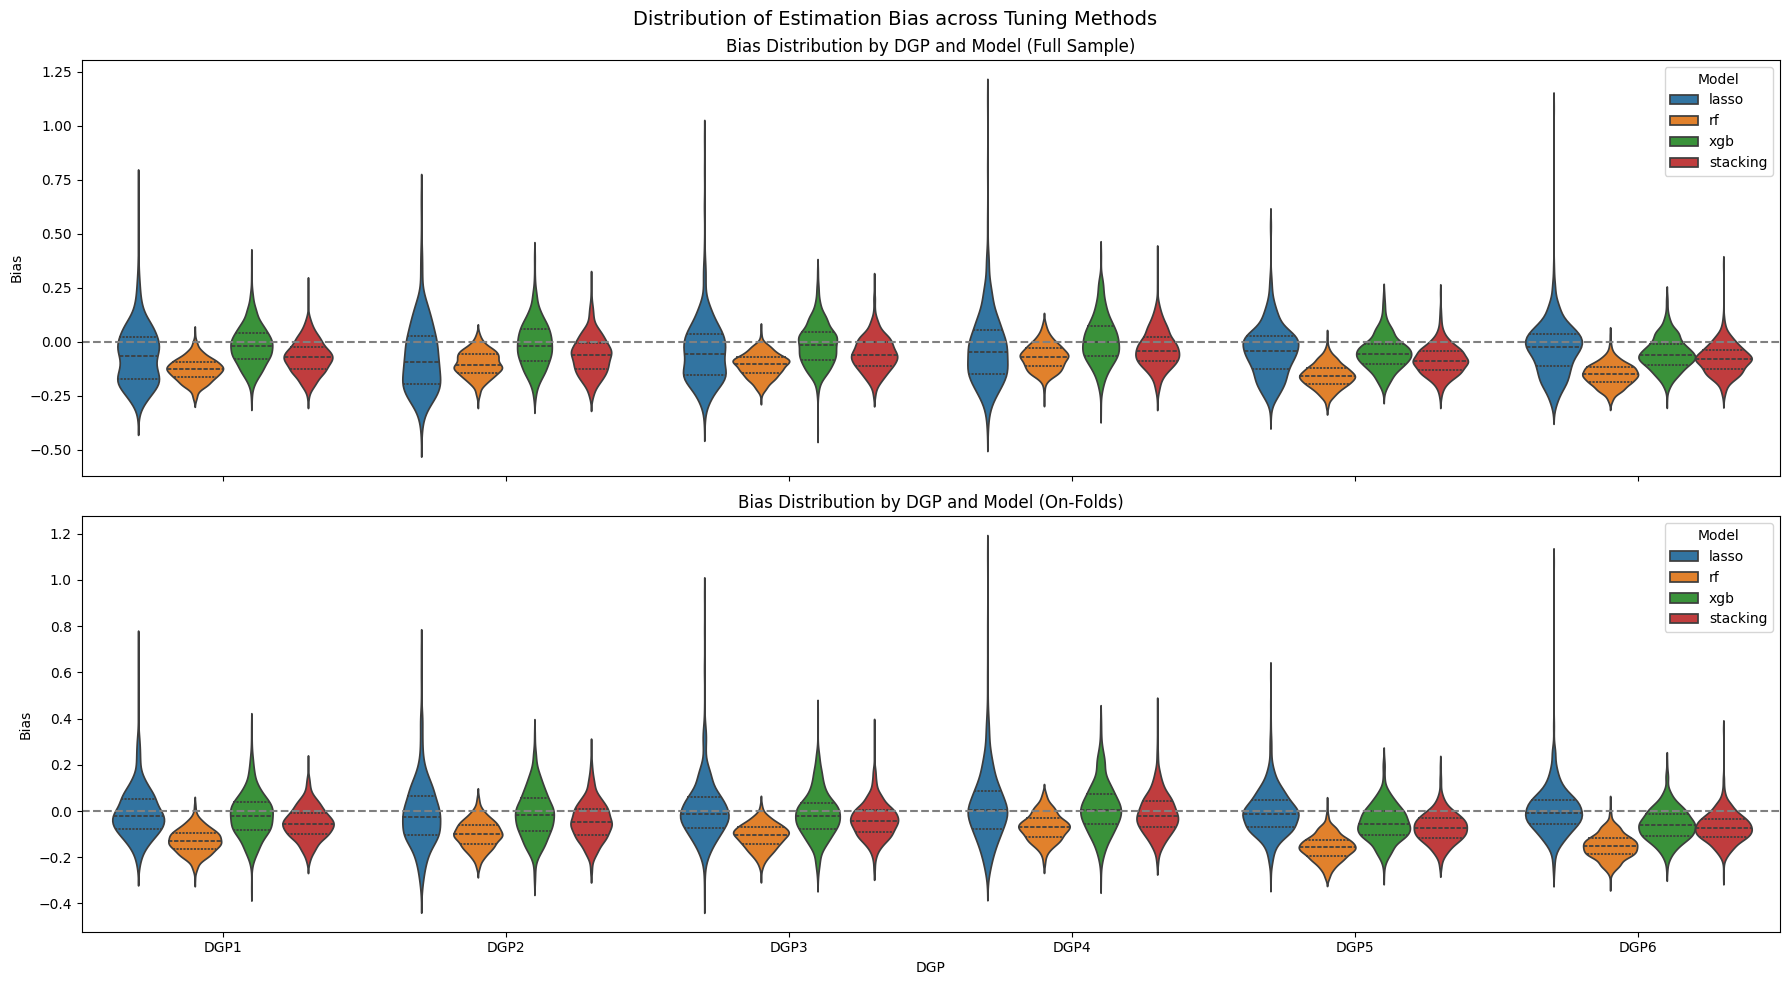

In [ ]:
def plot_theta_violin_dual(dfs_fs, dfs_of, bias_col='bias'):

    def prepare_df(dfs):
        df_all = pd.concat(
            [df.assign(DGP=dgp.upper()) for dgp, df in dfs.items()],
            ignore_index=True
        )
        return df_all[df_all['model'] != 'oracle']

    df_fs = prepare_df(dfs_fs)
    df_of = prepare_df(dfs_of)

    fig, axes = plt.subplots(2, 1, figsize=(18, 10), sharex=True)

    sns.violinplot(
        data=df_fs,
        x='DGP',
        y=bias_col,
        hue='model',
        inner='quartile',
        ax=axes[0]
    )
    axes[0].axhline(0.0, linestyle='--', color='gray')
    axes[0].set_title('Bias Distribution by DGP and Model (Full Sample)')
    axes[0].set_ylabel('Bias')
    axes[0].set_xlabel('')
    axes[0].legend(title='Model')

    sns.violinplot(
        data=df_of,
        x='DGP',
        y=bias_col,
        hue='model',
        inner='quartile',
        ax=axes[1]
    )
    axes[1].axhline(0.0, linestyle='--', color='gray')
    axes[1].set_title('Bias Distribution by DGP and Model (On-Folds)')
    axes[1].set_ylabel('Bias')
    axes[1].set_xlabel('DGP')
    axes[1].legend(title='Model')

    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.suptitle("Distribution of Estimation Bias across Tuning Methods", fontsize=14)
    plt.show()

plot_theta_violin_dual(dfs_fs, dfs_of, bias_col='bias')


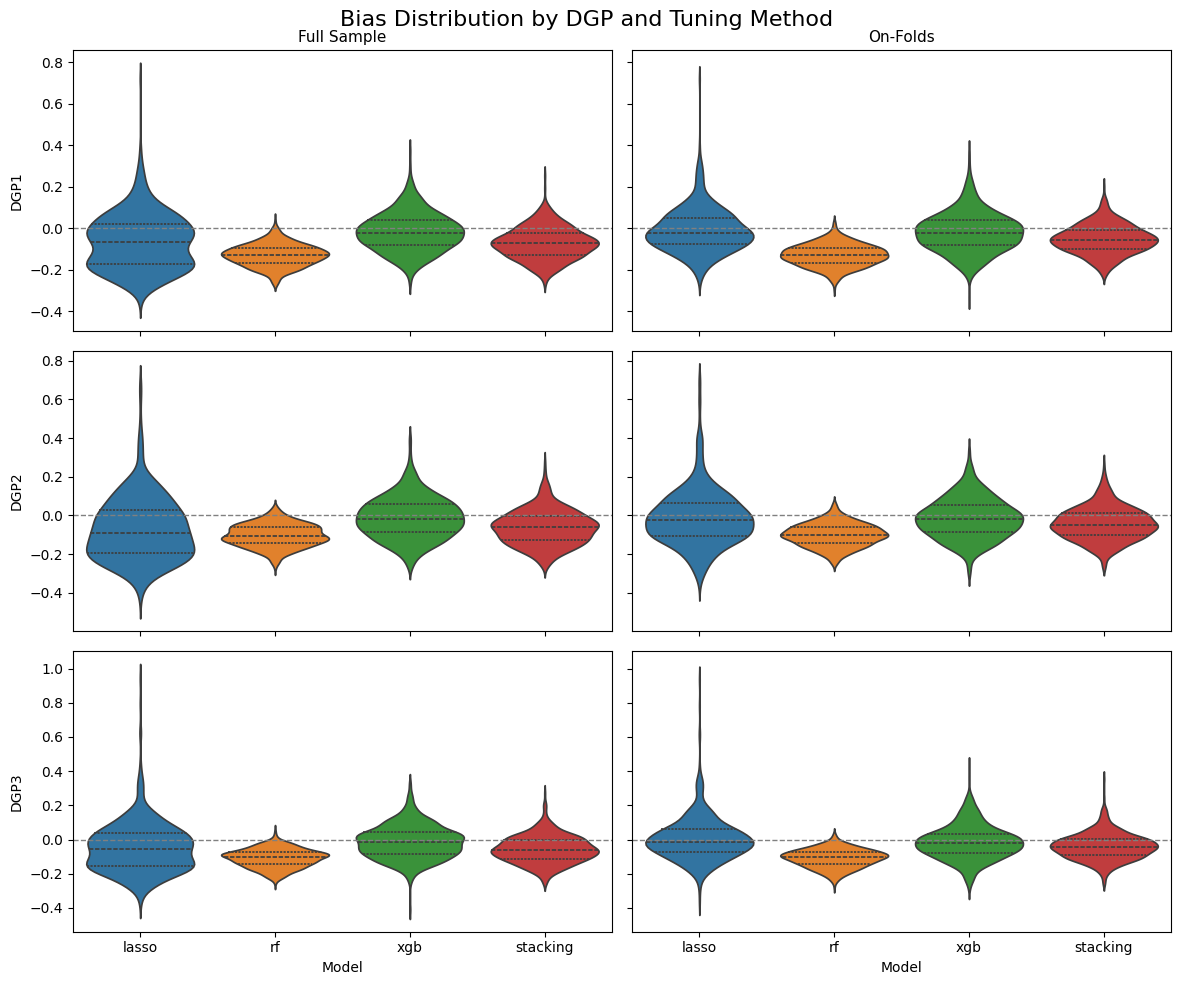

In [ ]:
def plot_theta_violin_grid(dfs_fs, dfs_of, bias_col='bias'):

    def prepare_df(dfs, method_label):
        df_all = pd.concat(
            [df.assign(DGP=dgp.upper(), Tuning=method_label) for dgp, df in dfs.items()],
            ignore_index=True
        )
        return df_all[df_all['model'] != 'oracle']

    df_all = pd.concat([
        prepare_df(dfs_fs, "Full Sample"),
        prepare_df(dfs_of, "On-Folds")
    ])

    dgps = ['DGP1', 'DGP2', 'DGP3']
    tuning_methods = ['Full Sample', 'On-Folds']

    fig, axes = plt.subplots(nrows=len(dgps), ncols=2, figsize=(12, 10), sharey='row', sharex=True)

    for i, dgp in enumerate(dgps):
        for j, tuning in enumerate(tuning_methods):
            ax = axes[i, j]
            df_sub = df_all[(df_all['DGP'] == dgp) & (df_all['Tuning'] == tuning)]
            sns.violinplot(
                data=df_sub,
                x='model',
                y=bias_col,
                hue='model',
                inner='quartile',
                ax=ax,
                palette=color_map_models,
                legend=False
            )
            ax.axhline(0.0, linestyle='--', color='gray', linewidth=1)
            if i == 0:
                ax.set_title(tuning, fontsize=11)
            if j == 0:
                ax.set_ylabel(f"{dgp}", fontsize=10)
            else:
                ax.set_ylabel("")
            if i < len(dgps) - 1:
                ax.set_xlabel("")
            else:
                ax.set_xlabel("Model")
            ax.tick_params(axis='x', rotation=0)

            legend = ax.get_legend()
            if legend is not None:
                legend.remove()

    plt.suptitle("Bias Distribution by DGP and Tuning Method", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.show()

plot_theta_violin_grid(dfs_fs, dfs_of, bias_col='bias')